In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, Lars, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import warnings
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import t
from itertools import product
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from boruta import BorutaPy

In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         808 non-null    int64  
 1   Количество.комнат          808 non-null    int64  
 2   Студия                     808 non-null    int64  
 3   Общая.площадь              808 non-null    float64
 4   Этаж                       808 non-null    int64  
 5   Этажей.в.доме              808 non-null    int64  
 6   Парковка                   808 non-null    int64  
 7   Без.ремонта                808 non-null    int64  
 8   Дизайнерский               808 non-null    int64  
 9   Евроремонт                 808 non-null    int64  
 10  Косметический              808 non-null    int64  
 11  Балкон                     808 non-null    int64  
 12  Лоджия                     808 non-null    int64  
 13  Совмещенный.санузел        808 non-null    int64  

проведем предварительную обработку данных 

In [5]:
ids = test_data["id"]
train_data.drop("id", axis=1, inplace=True)
test_data.drop("id", axis=1, inplace=True)
key_col = 'Цена'
train_data.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,50.781176,4.894802,8.935644,0.142327,0.101485,0.024752,0.101485,0.772277,...,10.372525,4.674505,0.143564,7.788366,2.501238,13.263614,4.149752,6.754950,13.470297,2.699083e+06
std,0.996109,0.198046,19.827507,3.760826,4.754526,0.349601,0.302157,0.155466,0.302157,0.419622,...,15.397133,3.255991,0.378064,8.983450,1.636025,7.557860,5.955523,6.873569,8.068579,1.096460e+06
min,1.000000,0.000000,10.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,37.650000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,2.000000,0.000000,3.000000,1.000000,8.000000,1.000000,2.000000,7.000000,1.950000e+06
50%,2.000000,0.000000,48.000000,4.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,4.000000,4.000000,0.000000,6.000000,2.000000,13.000000,3.000000,5.000000,12.000000,2.550000e+06
75%,3.000000,0.000000,63.075000,6.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,12.000000,7.000000,0.000000,9.000000,4.000000,18.000000,5.000000,10.000000,19.000000,3.310000e+06
max,5.000000,1.000000,120.000000,24.000000,26.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,86.000000,14.000000,2.000000,67.000000,8.000000,42.000000,52.000000,40.000000,40.000000,6.800000e+06


получим список всех категориальных и числовых признаков

In [6]:
numeric = []
categorical = []
for name in train_data.columns:
    if train_data[name].nunique() > 5:
        numeric.append(name)
    else:
        categorical.append(name)
numeric.remove(key_col)
columns = numeric + categorical
print("Numeric features:", numeric)
print("Categorical features:", categorical)

Numeric features: ['Общая.площадь', 'Этаж', 'Этажей.в.доме', 'Год.постройки', 'Школа.1000', 'ВУЗ.1000', 'ТЦ.1000', 'Стоматология.1000', 'Почта.1000', 'Поликлиника.1000', 'Остановка.1000', 'Одежда..1000', 'Супер3кет.1000', 'Кафе.1000', 'АЗС.1000', 'Детский.сад.1000', 'Бар.1000', 'Банк.1000', 'Аптека.1000']
Categorical features: ['Количество.комнат', 'Студия', 'Парковка', 'Без.ремонта', 'Дизайнерский', 'Евроремонт', 'Косметический', 'Балкон', 'Лоджия', 'Совмещенный.санузел', 'Раздельный.санузел', 'Лифт', 'Грузовой.лифт', 'Мусоропровод', 'Аварийный', 'Железобетонные.перекрытия', 'Смешанные.перекрытия', 'Деревянные.перекрытия', 'Иные.перекрытия', 'Панельные.стены', 'Блочные.стены', 'Деревянные.стены', 'Кирпичные.стены', 'Монолитные.стены', 'Смешанные.стены', 'Парк.1000', 'Кинотеатр.1000']


нормализация числовых признаков

In [7]:
scaler = MinMaxScaler()
train_data[numeric] = scaler.fit_transform(train_data[numeric])
test_data[numeric] = scaler.fit_transform(test_data[numeric])
train_data.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,0.370738,0.169339,0.288985,0.142327,0.101485,0.024752,0.101485,0.772277,...,0.120611,0.333893,0.143564,0.116244,0.312655,0.315800,0.079803,0.168874,0.336757,2.699083e+06
std,0.996109,0.198046,0.180250,0.163514,0.198105,0.349601,0.302157,0.155466,0.302157,0.419622,...,0.179036,0.232571,0.378064,0.134081,0.204503,0.179949,0.114529,0.171839,0.201714,1.096460e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,0.251364,0.043478,0.125000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.023256,0.142857,0.000000,0.044776,0.125000,0.190476,0.019231,0.050000,0.175000,1.950000e+06
50%,2.000000,0.000000,0.345455,0.130435,0.291667,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.046512,0.285714,0.000000,0.089552,0.250000,0.309524,0.057692,0.125000,0.300000,2.550000e+06
75%,3.000000,0.000000,0.482500,0.217391,0.333333,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.139535,0.500000,0.000000,0.134328,0.500000,0.428571,0.096154,0.250000,0.475000,3.310000e+06
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.800000e+06


отберем информативные признаки

In [8]:
'''x_train = train_data.drop(columns=[key_col]) 
y_train = train_data[key_col]

model = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=5)  
boruta_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)  
boruta_selector.fit(x_train, y_train)
feature_ranks = list(zip(x_train.columns, boruta_selector.ranking_))
feature_ranks'''

"x_train = train_data.drop(columns=[key_col]) \ny_train = train_data[key_col]\n\nmodel = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=5)  \nboruta_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)  \nboruta_selector.fit(x_train, y_train)\nfeature_ranks = list(zip(x_train.columns, boruta_selector.ranking_))\nfeature_ranks"

<Axes: >

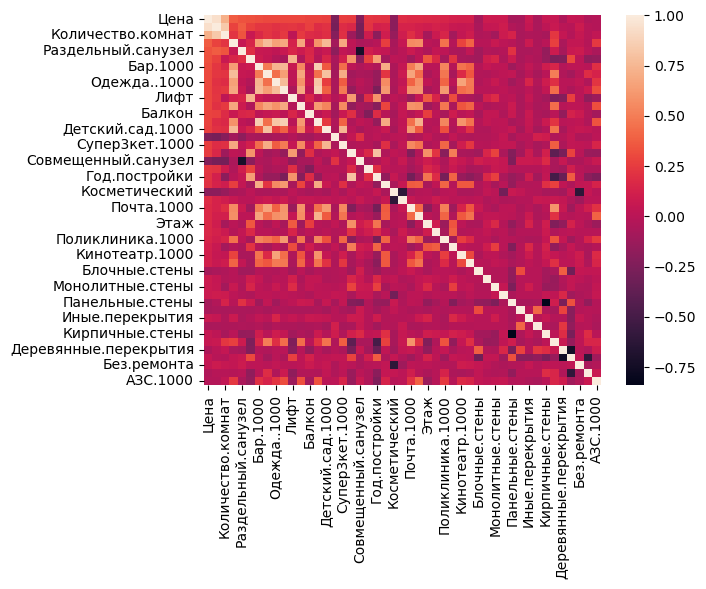

In [9]:
sorted_idx = train_data.corr()[key_col].abs().sort_values(ascending=False).index[:47]
corr_matrix = train_data[sorted_idx].corr()
sns.heatmap(corr_matrix)

определим наиболее кореллирующие признаки с ключом 

<Axes: >

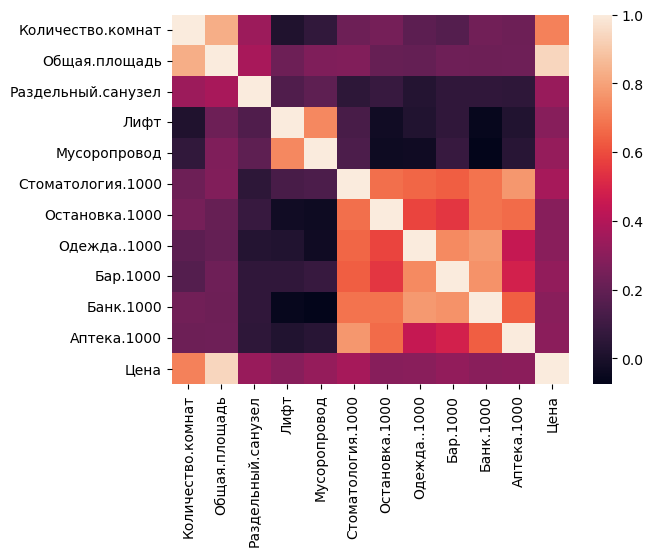

In [10]:
corr_matrix = train_data.corr()
threshold = 0.29
corr_price_matrix = train_data.corrwith(train_data[key_col]).abs()
weak_corr_features = set(corr_matrix[corr_price_matrix <= threshold].index)
train_data.drop(weak_corr_features, axis=1, inplace=True)
test_data.drop(weak_corr_features, axis=1, inplace=True)
sns.heatmap(train_data.corr())

удалим наиболее кореллирующие признаки

In [11]:
'''feature_select = train_data.drop(key_col, axis=1)
corr_series = feature_select.corr().abs().stack().sort_values()
corr_series = corr_series[~corr_series.duplicated()]
threshold = 0.75
drops = set([feature2 for (feature1, feature2), corr in corr_series.items() if
             corr > threshold and corr != 1])
train_data.drop(drops, axis=1, inplace=True)
test_data.drop(drops, axis=1, inplace=True)
sns.heatmap(train_data.corr(), annot=True)'''

'feature_select = train_data.drop(key_col, axis=1)\ncorr_series = feature_select.corr().abs().stack().sort_values()\ncorr_series = corr_series[~corr_series.duplicated()]\nthreshold = 0.75\ndrops = set([feature2 for (feature1, feature2), corr in corr_series.items() if\n             corr > threshold and corr != 1])\ntrain_data.drop(drops, axis=1, inplace=True)\ntest_data.drop(drops, axis=1, inplace=True)\nsns.heatmap(train_data.corr(), annot=True)'

In [12]:
x = train_data.drop(columns=key_col, axis=1)
y = train_data[key_col]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

теперь начнем построение регрессионных моделей

In [13]:
def count_criteria(model, x_test, y_test):
    y_pred = model.predict(x_test) if hasattr(model, "predict") else model.fit(x_test)[0]
    r_sq = r2_score(y_test, y_pred)
    adj_r_sq = 1 - (1 - r_sq) * (len(y_test) - 1) / (len(y_test) - x_test.shape[1] - 1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    aic = len(y_test) * np.log(rmse ** 2) + 2 * x_test.shape[1]
    bic = len(y_test) * np.log(rmse ** 2) + x_test.shape[1] * np.log(len(y_test))
    return {"R^2": r_sq, "Adj R^2": adj_r_sq, "RMSE": rmse, "AIC": aic, "BIC": bic}


def get_stats_vals(fitted_model, x_test, y_test):
    n, p = x_test.shape
    mse = mean_squared_error(y_test, fitted_model.predict(x_test))
    std_errs = np.sqrt(np.diag(np.linalg.inv(x_test.T @ x_test)) * mse)
    coefs = fitted_model.coef_ if hasattr(fitted_model, "coef_") else fitted_model.params.values
    t_values = coefs / std_errs
    p_values = 2 * (1 - t.cdf(np.abs(t_values), df=n - p - 1))
    confidence_level = 0.95
    alpha = 1 - confidence_level
    t_critical = t.ppf(1 - alpha / 2, n - p - 1)
    conf_intervals = list(zip(coefs - t_critical * std_errs, coefs + t_critical * std_errs))
    is_hypothesis_rejected = np.abs(t_values) > t_critical
    data = {
        'Name': x_test.columns,
        'Estimate': coefs,
        'Standard Error': std_errs,
        't-value': t_values,
        'p-value': p_values,
        '95% Confidence Interval': conf_intervals,
        'Is hypothesis rejected': is_hypothesis_rejected
    }
    return pd.DataFrame(data)


def sk_get_best(unfitted_model, params, x_train, y_train):
    grid = GridSearchCV(unfitted_model, params, cv=5,
                        scoring="neg_mean_squared_error")
    grid.fit(x_train, y_train)
    return grid.best_estimator_


def sm_get_best(unfitted_model, params):
    kfolder = KFold(n_splits=5, shuffle=True)
    param_keys = params.keys()
    fitted = []
    for param in product(*params.values()):
        param_dict = dict(zip(param_keys, param))
        for train_idx, test_idx in kfolder.split(x):
            x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            cur_model = unfitted_model(y_train, x_train, **param_dict)
            fitted_model = cur_model.fit()
            y_pred = fitted_model.predict(x_test)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            fitted.append({"model": fitted_model, "score": rmse})
    return min(fitted, key=lambda m_dict: m_dict["score"])["model"]


def show_model(model_name, model, stat_vals):
    print(model_name)
    print(model)
    print(stat_vals)


def build_sk_model(model_name, model_params, list_models):
    model = model_params["model"]
    if model_params["selector"] == "SFS":
        selector = SequentialFeatureSelector(model)
        selector.fit(x_train, y_train)
        features = selector.get_support()
        x_train_sel, x_test_sel = x_train.loc[:, features], x_test.loc[:,
                                                                features]
    elif model_params["selector"] == "Poly":
        selector = PolynomialFeatures(degree=2)
        x_train_sel, x_test_sel = selector.fit_transform(
            x_train), selector.fit_transform(x_test)
    else:
        x_train_sel, x_test_sel = x_train, x_test
    fitted_model = sk_get_best(model, model_params["params"], x_train_sel, y_train)
    model_stats = count_criteria(fitted_model, x_test_sel, y_test)
    model_stats["Model name"] = model_name
    model_stats["Model"] = fitted_model
    list_models = list_models.append(model_stats, ignore_index=True)
    if model_params["selector"] not in ["Poly", "Not parametric"]:
        coeff = get_stats_vals(fitted_model, x_test_sel, y_test)
    else:
        coeff = "Невозможно получить информацию о коэффициентах"
    show_model(model_name, model_stats, coeff)
    return list_models

def build_sm_model(cur_model_name, cur_model_params, list_models):
    fitted_model = sm_get_best(cur_model_params["model"], cur_model_params["params"])
    model_stats = count_criteria(fitted_model, x_test, y_test)
    model_stats["Model name"] = cur_model_name
    model_stats["Model"] = fitted_model
    list_models = list_models.append(model_stats, ignore_index=True)
    values = get_stats_vals(fitted_model, x_test, y_test)
    show_model(cur_model_name, model_stats, values)
    return list_models


теперь приступим напрямую к моделям

In [14]:
models_dict = {
    "Линейная регрессия": {
        "model": LinearRegression(),
        "params": {
            'fit_intercept': [True, False],
            'positive': [True, False],
        },
        "selector": "SFS",
        "kind": "sk"
    },
    "Лассо регрессия": {
        "model": Lasso(),
        "params": {
            'alpha': [0.01, 0.1, 1, 10, 100],
            'fit_intercept': [True, False],
            'positive': [True, False],
            'warm_start': [True, False],
            "selection": ["cyclic", "random"]
        },
        "selector": None,
        "kind": "sk"
    },
    "Гребневая регрессия": {
        "model": Ridge(),
        "params": {
            'alpha': [0.01, 0.1, 1, 10, 100],
            'fit_intercept': [True, False],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
        },
        "selector": None,
        "kind": "sk"
    },
    "Elastic-Net": {
        "model": ElasticNet(),
        "params": {
            'alpha': [0.01, 0.1, 1, 10, 100],
            'l1_ratio': [0.2, 0.5, 0.8],
            'fit_intercept': [True, False],
        },
        "selector": None,
        "kind": "sk"
    },
    "Метод наименьших углов": {
        "model": Lars(),
        "params": {
            'n_nonzero_coefs': [100, 500, 1000],
            'fit_intercept': [True, False],
            'normalize': [True, False],
        },
        "selector": "SFS",
        "kind": "sk"
    },
    "Байесовская регрессия": {
        "model": BayesianRidge(),
        "params": {
            'n_iter': [200, 400, 600],
            'tol': [1e-4, 1e-5, 1e-6],
            'alpha_1': [1e-6, 1e-7, 1e-8],
            'alpha_2': [1e-6, 1e-7, 1e-8],
            'lambda_1': [1e-6, 1e-7, 1e-8],
            'lambda_2': [1e-6, 1e-7, 1e-8],
        },
        "selector": None,
        "kind": "sk"
    },
    "Обобщённая линейная регрессия": {
        "model": sm.GLS,
        "params": {
            'sigma': [0.1, 0.5, 1.0],
            'hasconst': [True, False],
            'cov_type': ['nonrobust', 'HC0', 'HC1', 'HC2', 'HC3', 'HAC'],
            'kernel': ['bartlett', 'uniform', 'parzen', 'quadratic', 'triangular', 'cosine'],
            'dew': [False, True]
        },
        "selector": None,
        "kind": "sm"
    },
    "Взвешенный МНК": {
        "model": sm.WLS,
        "params": {
            'missing': ['none', 'drop', 'raise'],
            'hasconst': [True, False],
            'cov_type': ['nonrobust', 'HC0', 'HC1', 'HC2', 'HC3', 'HAC'],
            'kernel': ['bartlett', 'uniform', 'parzen', 'quadratic', 'triangular', 'cosine']
        },
        "selector": None,
        "kind": "sm"
    },
    "Полиномиальная регрессия": {
        "model": LinearRegression(),
        "params": {
            'fit_intercept': [True, False],
            'positive': [True, False],
        },
        "selector": "Poly",
        "kind": "sk"
    },
    "Непараметрическая регрессия": {
        "model": KNeighborsRegressor(),
        "params": {
            "n_neighbors": [2, 3, 4, 5, 6],
        },
        "selector": "Not parametric",
        "kind": "sk"
    },
        "Сплайновая регрессия": {
        "model": sm.OLS,
        "params": {
            'formula': ['bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)'],
        },
        "selector": None,
        "kind": "sm"
    },

}


In [15]:
def build_model(models_dict):
    list_models = pd.DataFrame(
    {
        "Model name": [],
        "Model": [],
        "R^2": [],
        "Adj R^2": [],
        "RMSE": [],
        "AIC": [],
        "BIC": []
    }
)
    for model_name, model_params in models_dict.items():
        kind = model_params["kind"]
        if kind == "sm":
            list_models = build_sm_model(model_name, model_params, list_models)
        else:
            list_models = build_sk_model(model_name, model_params, list_models)
    
    return list_models


list_models = build_model(models_dict)
models = list_models["Model"]
list_models.drop("Model", axis=1, inplace=True)


Линейная регрессия
{'R^2': 0.8974820184142098, 'Adj R^2': 0.8953191917984759, 'RMSE': 356658.1167803285, 'AIC': 6223.283011677616, 'BIC': 6240.748318894319, 'Model name': 'Линейная регрессия', 'Model': LinearRegression()}
                Name      Estimate  Standard Error    t-value       p-value  \
0  Количество.комнат -2.266541e+05    43629.302782  -5.194998  4.411160e-07   
1      Общая.площадь  6.417369e+06   249446.079566  25.726478  0.000000e+00   
2               Лифт  1.065299e+05    48218.276789   2.209325  2.810903e-02   
3  Стоматология.1000  4.006967e+05   175790.693709   2.279397  2.353328e-02   
4     Остановка.1000  5.676721e+05   167751.765501   3.384001  8.358313e-04   

                     95% Confidence Interval  Is hypothesis rejected  
0  (-312604.90875511756, -140703.3606790427)                    True  
1     (5925954.327032891, 6908783.859125084)                    True  
2   (11538.691068313507, 201521.01709846128)                    True  
3     (54384.813421

c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel', 'dew']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel', 'dew']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel', 'dew']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel', 'dew']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel', 'dew']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:1

Обобщённая линейная регрессия
{'R^2': 0.8803952228610334, 'Adj R^2': 0.8746997572829874, 'RMSE': 385235.54479883995, 'AIC': 6272.742572200901, 'BIC': 6311.166248077647, 'Model name': 'Обобщённая линейная регрессия', 'Model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000018F22728760>}
                  Name      Estimate  Standard Error    t-value   p-value  \
0    Количество.комнат -1.368136e+05    48462.819524  -2.823062  0.005172   
1        Общая.площадь  6.490384e+06   276311.546677  23.489368  0.000000   
2   Раздельный.санузел -3.171818e+04    53318.290746  -0.594884  0.552504   
3                 Лифт  1.414358e+05    75003.403415   1.885725  0.060587   
4         Мусоропровод  9.114823e+04    79390.459744   1.148101  0.252115   
5    Стоматология.1000 -2.701694e+05   261281.955346  -1.034015  0.302211   
6       Остановка.1000  9.069634e+05   210122.610700   4.316353  0.000024   
7         Одежда..1000  3.131856e+05   286286.031922   1.093960  0

c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['cov_type', 'kernel']
  warnings.warn(msg, ValueWarning)
c:\Users\sb170\.conda\envs\anacondOchka\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['

Взвешенный МНК
{'R^2': 0.8806893777553876, 'Adj R^2': 0.8750079195532632, 'RMSE': 384761.53078626044, 'AIC': 6272.144204112193, 'BIC': 6310.567879988938, 'Model name': 'Взвешенный МНК', 'Model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000018F1954CB80>}
                  Name      Estimate  Standard Error    t-value   p-value  \
0    Количество.комнат -1.438404e+05    48403.188330  -2.971714  0.003275   
1        Общая.площадь  6.550006e+06   275971.558462  23.734352  0.000000   
2   Раздельный.санузел -1.298850e+04    53252.685126  -0.243903  0.807522   
3                 Лифт  1.326067e+05    74911.115295   1.770187  0.078015   
4         Мусоропровод  1.202555e+05    79292.773560   1.516601  0.130735   
5    Стоматология.1000 -2.999073e+05   260960.460329  -1.149244  0.251644   
6       Остановка.1000  9.018099e+05   209864.064823   4.297114  0.000026   
7         Одежда..1000  3.348354e+05   285933.770578   1.171024  0.242796   
8             Бар.1

In [16]:
print(list_models)

                       Model name       R^2   Adj R^2           RMSE  \
0              Линейная регрессия  0.897482  0.895319  356658.116780   
1                 Лассо регрессия  0.898769  0.893948  354413.175789   
2             Гребневая регрессия  0.898775  0.893955  354401.319586   
3                     Elastic-Net  0.888600  0.883295  371787.095975   
4          Метод наименьших углов  0.897482  0.895319  356658.116780   
5           Байесовская регрессия  0.898736  0.893913  354470.811848   
6   Обобщённая линейная регрессия  0.880395  0.874700  385235.544799   
7                  Взвешенный МНК  0.880689  0.875008  384761.530786   
8        Полиномиальная регрессия  0.892428  0.841266  365343.433305   
9     Непараметрическая регрессия  0.696227  0.681762  613940.970632   
10           Сплайновая регрессия  0.880499  0.874808  385068.652725   

            AIC          BIC  
0   6223.283012  6240.748319  
1   6232.214276  6270.637952  
2   6232.198017  6270.621693  
3   6255.47

In [17]:
print("Лучшая модель")
print(list_models[list_models["RMSE"] == list_models["RMSE"].min()]["Model name"])

Лучшая модель
2    Гребневая регрессия
Name: Model name, dtype: object


In [18]:


print(test_data)

     Количество.комнат  Общая.площадь  Раздельный.санузел  Лифт  Мусоропровод  \
0                    1       0.204545                   1     1             1   
1                    1       0.172727                   0     0             0   
2                    1       0.194697                   0     1             1   
3                    4       0.541667                   1     1             1   
4                    1       0.227273                   1     0             0   
..                 ...            ...                 ...   ...           ...   
778                  2       0.272727                   1     0             0   
779                  4       0.545455                   0     1             1   
780                  1       0.181818                   1     1             1   
781                  2       0.310606                   1     0             0   
782                  2       0.289394                   1     0             0   

     Стоматология.1000  Ост

In [19]:

best_model_index = list_models["RMSE"].idxmax()
model = models[best_model_index]
y_pred = model.predict(test_data)

# Создание DataFrame для submission
submission = pd.DataFrame({'id': ids, 'Цена': y_pred})

# Сохранение DataFrame в CSV файл
submission.to_csv('submission.csv', index=False)

print("Файл submission.csv сохранен.")

Файл submission.csv сохранен.
